# Stitching and Merging Networks
## Create Bilayer Topology with Merging and Stitching

OpenPNM includes numerous tools for manipulating and altering the topology.  Most of these are found in the **topotools** submodule. This example will illustrate how to 'merge' and 'stitch' two distinct networks, even if they have different lattice spacing. In this example we'll create a coarse and a fine network then join them together to make a network with two distinct layers.  

Start by creating a network with a large lattice spacing:

In [1]:
import scipy as sp
import numpy as np
np.set_printoptions(precision=4)
import matplotlib.pyplot as plt
import openpnm as op
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
np.random.seed(10)
ws = op.Workspace()
ws.settings["loglevel"] = 40

In [2]:
coarse_net = op.network.Cubic(shape=[10, 10, 10], spacing=50e-6,
                              name='coarse_net')
print(coarse_net)


══════════════════════════════════════════════════════════════════════════════
coarse_net : <openpnm.network.Cubic at 0x7f7dced03c20>
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Properties                                                   Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  1  pore.coords                                                   1000 / 1000
  2  throat.conns                                                  2700 / 2700
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Labels                                                 Assigned Locations
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  1  pore.back                                                             100
  2  pore.bottom                                                           100
  3  pore.front                                                            

The ```coarse_net``` network has 1000 pores in a cubic lattice with a spacing of 50 um for a total size of 500 um per size.  Next, we'll make another network with smaller spacing between pores, but with the same total size.

In [3]:
fine_net = op.network.Cubic(shape=[25, 25, 5], spacing=20e-6, name='fine_net')
# Add this label for easy identification below
fine_net.set_label(pores=fine_net.Ps, label='fine')
print(fine_net)


══════════════════════════════════════════════════════════════════════════════
fine_net : <openpnm.network.Cubic at 0x7f7dced03bd0>
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Properties                                                   Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  1  pore.coords                                                   3125 / 3125
  2  throat.conns                                                  8500 / 8500
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Labels                                                 Assigned Locations
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  1  pore.back                                                             125
  2  pore.bottom                                                           625
  3  pore.fine                                                            312

## Merge Two Networks

These two networks are totally independent of each other, and actually both spatially overlap each other since the network generator places the pores at the [0, 0, 0] origin.  Combining these networks into a single network is possible using the ``merge`` function, but first we must make some adjustments.  For starters, let's shift the ``fine_net`` along the z-axis so it is beside the ``coarse_net`` to give the layered effect:

In [4]:
fine_net['pore.coords'] += np.array([0, 0, 10 * 50e-6])

Before proceeding, let's quickly check that the two networks are indeed spatially separated now.  OpenPNM as a rule does *not* provide extensively visualization capabilities since there are so many other packages that do it very well.  However, we've found it useful to have a quick way of checking the network, so provide two tools in the ``topotools`` module: ``plot_connections`` and ``plot_coordinates``.  Below we'll use ``plot_connections``:

AttributeError: module 'openpnm.topotools' has no attribute 'plot_connections'

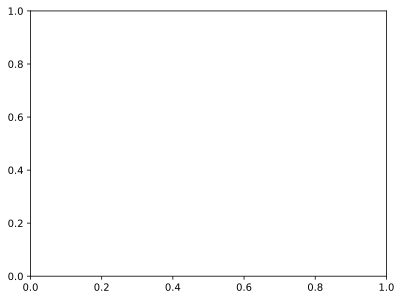

In [5]:
fig, ax = plt.subplots()
op.topotools.plot_connections(coarse_net, c='b', alpha=0.5, ax=ax)
op.topotools.plot_connections(fine_net, c='r', alpha=0.5, ax=ax)

As can be seen below, ```fine_net``` (orange) has been repositioned above the ```coarse_net``` (blue) because we shifted the z-coordinate by 500 um. (10 pores as 50 um per pore).

But this above plotting was accomplished by sending *different* networks to the same plot.  The ``merge`` function let's us combine the two networks together, as follows:

In [6]:
op.topotools.merge_networks(network=coarse_net, donor=fine_net)

Now when we plot the coarse network it will contain both domains:

In [7]:
op.topotools.plot_connections(coarse_net)

AttributeError: module 'openpnm.topotools' has no attribute 'plot_connections'

## Stitch Two Networks
Merging networks is a basic operation that does not actually join the pores on the top of the coarse network to those on the bottom of the fine network. A merge is useful is you have a specific plan for how to join or "stitch" these two domains together. If just want pores connected to their nearest counterpart(s) on the opposite domain, you can use the ``stitch``.  The ```stitch``` function uses Euclidean distance to determine which pore is each face is nearest each other, and connects them. 

First let's return the domain to contain only the pores from the coarse network using the ``trim`` function.

In [8]:
op.topotools.trim(network=coarse_net, pores=coarse_net.pores('pore.fine'))

Note that trimming pores also deletes all their associated throats, so there is no need to specify these.

Before doing the stitch, let's label the throats on each network so we can identify the newly added ones after the stitch:

In [9]:
coarse_net.set_label(throats=coarse_net.Ts, label='coarse')
fine_net.set_label(throats=fine_net.Ts, label='fine')

In [10]:
op.topotools.stitch(network=coarse_net,
                    donor=fine_net,
                    P_network=coarse_net.pores('top'),
                    P_donor=fine_net.pores('bottom'),
                    len_max=4e-5)

The value of ``len_max`` limits the maximum distance beyond which two pores are not considered connected.  This value must be selected carefully, and requires doing some trial-and-error or trigonometry to figure out the appropriate distances.  A large value will basically connect all the pores on both faces to each other.

And we can now visualize the result using OpenPNM's plotting tools, but let's plot the coarse, fine and stitched throats on different graphs:

In [11]:
op.topotools.plot_connections(coarse_net,
                              throats=coarse_net.throats('coarse'),
                              c='r', alpha=0.25)
op.topotools.plot_connections(coarse_net,
                              throats=coarse_net.throats('fine'),
                              c='b', alpha=0.25)
op.topotools.plot_connections(coarse_net,
                              throats=coarse_net.throats('stitched'),
                              c='g', alpha=0.9)

AttributeError: module 'openpnm.topotools' has no attribute 'plot_connections'

Or plotting all together:

AttributeError: module 'openpnm.topotools' has no attribute 'plot_connections'

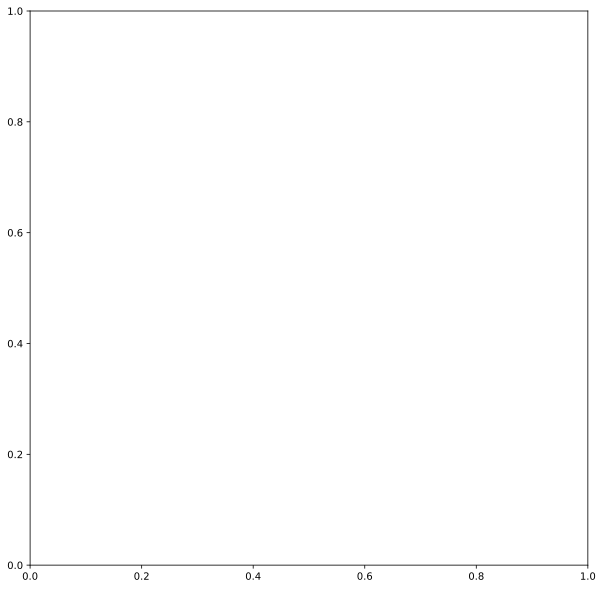

In [12]:
fig, ax = plt.subplots(figsize=[10, 10])
op.topotools.plot_connections(coarse_net,
                              throats=coarse_net.throats('coarse'),
                              c='r', alpha=0.25, ax=ax)
op.topotools.plot_connections(coarse_net,
                              throats=coarse_net.throats('fine'),
                              c='b', alpha=0.25, ax=ax)
op.topotools.plot_connections(coarse_net,
                              throats=coarse_net.throats('stitched'),
                              c='g', alpha=0.9, ax=ax)